# **Music Genre Classification using RNN(LSTM)**

We'll build an end to end deep learning model that:
- Takes audio input (`.wav` files)
- Extracts MFCC features
- Trains an LSTM model to classify music into genres
- `Deploys the model using **Gradio** to predict on any new audio file`

Dataset: **GTZAN Genre Dataset** (10 genres, 100 files each)


In [26]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"manavkateja","key":"0ab0d9f59851ca27f7c11b8dad0a0123"}'}

In [27]:
import os
os.rename("kaggle (1).json", "kaggle.json")

In [28]:
# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [29]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip gtzan-dataset-music-genre-classification.zip

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  gtzan-dataset-music-genre-classification.zip
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [30]:
import os
os.listdir("/content")

['.config',
 '.gradio',
 'eona-emotional-ambient-pop-351436.mp3',
 'Data',
 'genre_model.keras',
 'kaggle.json',
 'gtzan-dataset-music-genre-classification.zip',
 'label_encoder.joblib',
 'sample_data']

In [31]:
os.listdir("/content/Data")

['features_3_sec.csv',
 'genres_original',
 'features_30_sec.csv',
 'images_original']

# Getting Our DATA Ready

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gradio as gr
import joblib
import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [33]:
DATA_PATH = "/content/Data/genres_original"

def extract_features(file_path):
  try:
    audio, sample_rate = librosa.load(file_path, duration=30)
    # duration =30 means load only first 30 sec, librosa.load raw audio into numpy array, sample rate(def =22050 hz =22050samples/sec)
    # if file is 22050 & duraation is 30, then audio shape is(661500, )
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13) #( ex mfcc shape 13, 173)
    mfcc = mfcc.T # (ex shape 173,13)
    if mfcc.shape[0] >=130:
      return mfcc[:130] # (130,13) # 130 is good number not too much ram,& good data to learn
  except:
    return None

# Final Output of This Function
# You get a NumPy array of shape (130, 13)

# Each song = 1 sample
# Each sample = sequence of 130 time steps
# Each time step = 13 MFCC values (features)

# This becomes one training input for your model.

In [34]:
features = []
labels = []
geners = os.listdir(DATA_PATH)

for genre in geners: # genre is pop, rock , blues and datapath = like this /content/genres/
  genre_path = os.path.join(DATA_PATH, genre)  # it will join both ex /content/genres/pop
  for files in os.listdir(genre_path): # filenames like that ['pop.00000.wav', 'pop.00001.wav', ...]
    file_path = os.path.join(genre_path, files) # it will join with genrepath, ex /content/genres/pop/pop.00001.wav
    mfcc = extract_features(file_path)
    if mfcc is not None:
      features.append(mfcc)
      labels.append(genre)

x = np.array(features)
y = np.array(labels)

print(f'Feature Shape: {x.shape}')
print(f'Labels Shape: {y.shape}')

Feature Shape: (999, 130, 13)
Labels Shape: (999,)


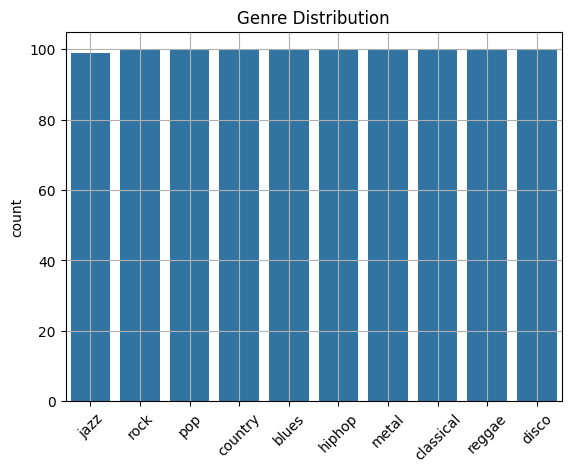

In [35]:
sns.countplot(x=y)
plt.title("Genre Distribution")
plt.xticks(rotation=45)
plt.grid()
plt.show()


# Encoding the labels and splits

In [36]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)# Might be like:'jazz' → 0,'metal' → 1, 'pop' → 2', rock' → 3,
y_cat = to_categorical(y_encoded)

x_train, x_test, y_train, y_test = train_test_split(x, y_cat, test_size=0.2, random_state = 42)

In [37]:
y_encoded

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2,

In [38]:
y_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Making a model

In [39]:
# model = Sequential([
#     LSTM(64, input_shape=(130,13)),
#     Dropout(0.3), #Randomly turns off 30% of neurons to prevent overfitting
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(10, activation = 'sigmoid') # 10 genres
# ])

# model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



# model.build(input_shape=(None, 130, 13))# none = batch size


# model.summary()

# `we change model to see better ops`

In [40]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(130, 13)),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),  # slower learning rate
    metrics=['accuracy']
)

model.build(input_shape=(None, 130, 13))# none = batch size


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 130, 128)       │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 130, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,922 (495.79 KB)

 Trainable params: 126,922 (495.79 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(
    x_train,
    y_train,
    epochs = 30,
    batch_size = 32,
    validation_data = (x_test, y_test),
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1442 - loss: 2.2986 - val_accuracy: 0.2600 - val_loss: 2.1693
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2256 - loss: 2.1823 - val_accuracy: 0.3100 - val_loss: 2.0597
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2867 - loss: 2.0629 - val_accuracy: 0.3500 - val_loss: 1.9094
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3403 - loss: 1.9456 - val_accuracy: 0.3650 - val_loss: 1.7978
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3287 - loss: 1.8610 - val_accuracy: 0.3700 - val_loss: 1.7285
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3743 - loss: 1.7193 - val_accuracy: 0.4100 - val_loss: 1.6174
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4351 - loss: 1.6299 - val_accuracy: 0.4200 - val_loss: 1.6017
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5107 - loss: 1.5069 - val_accuracy: 0.4200 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Classification Report:
              precision    recall  f1-score   support

       blues       0.40      0.40      0.40        15
   classical       0.74      0.89      0.81        19
     country       0.44      0.30      0.36        23
       disco       0.45      0.25      0.32        20
      hiphop       0.48      0.44      0.46        27
        jazz       0.70      0.33      0.45        21
       metal       0.70      0.78      0.74        18
         pop       0.70      0.67      0.68        24
      reggae       0.32      0.36      0.34        22
        rock       0.12      0.36      0.19        11

    accuracy                           0.48       200
   macro avg       0.51      0.48      0.47       200
weighted avg       0.52      0.48      0.49       200



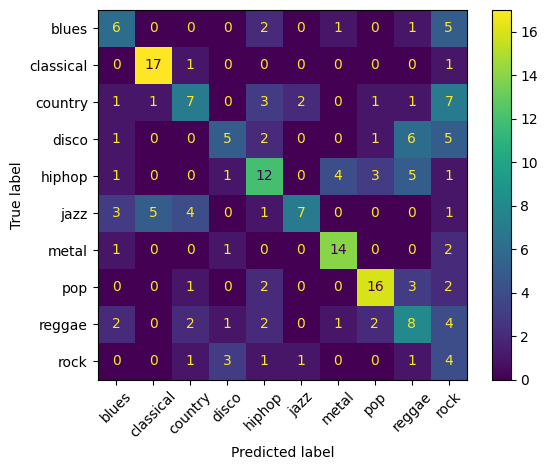

In [42]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.show()


In [43]:
model.save("genre_model.keras")
joblib.dump(le, "label_encoder.joblib")

['label_encoder.joblib']

In [44]:
!pip install --upgrade gradio --quiet

# we need to upload music file

In [ ]:

model = tf.keras.models.load_model("genre_model.keras")
le = joblib.load("label_encoder.joblib")

# Feature extraction for Gradio input
def extract_features_gradio(file_path):
    try:
        y, sr = librosa.load(file_path, duration=30)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T
        return mfcc[:130] if mfcc.shape[0] >= 130 else None
    except:
        return None

# Genre prediction function
def predict_genre(audio):
    mfcc = extract_features_gradio(audio.name)
    if mfcc is None:
        return "Invalid or short audio"

    # Predict
    pred = model.predict(mfcc[np.newaxis, ...])  # Add batch dimension
    label = le.inverse_transform([np.argmax(pred)])
    confidence = np.max(pred) * 100

    return f"Genre: {label[0]} ({confidence:.2f}%)"

# Gradio UI
gr.Interface(
    fn=predict_genre,
    inputs=gr.Audio(type="filepath"),
    outputs="text",
    title="BeatClassifier",
    description="Upload a .wav file to classify its genre using LSTM").launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://27e49e256918cf78e0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
